<a href="https://colab.research.google.com/github/Tavo826/DataScience/blob/main/Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Un chatbot se rige bajo los canceptos del NLP (Natural Language Processing) el cual se compone de dos elementos:

* **NLU (Natural Language Undestanding):** habilidad de las máquinas para entender el lenguaje humano

* **NLG (Natural Language Generation):** habilidad de una máquina de generar texto similar a las frases escritas por un humano

Si se le pregunta al chatbot "Hey, qué hay hoy en las noticias?", este separará la frase en 2 partes: intención y una identidad. LA intención para esta frase podría ser obtener_noticias como referencia a una acción que el ususario quiere realizar. La identidad se refiere a los detalles específicos de la frase, por ejemplo "hoy" será una identidad.

## Archivos del proyecto

* **Train_chatbot.py** - en este archivo se construirá y entrenará el modelo de aprendizaje profundo que puede clasificar e identificar lo que el usuario pregunta

* **Gui_Chatbot.py** - este archivo es donde se creará una interfaz gráfica de usuario para chatear con el chatbot entrenado

* **Intents.json** - el archivo intents contiene los datos que se usarán para entrenar el modelo. Estos datos son una colección de etiqueras con sus correspondientes patrones y respuestas

* **Chatbot_model.h5** - este es un archivo de formatp de datos jerárquicos en el cual se tienen guardados los pesos y la arquitectura del modelo entrenado

* **Classes.pkl** - puede usarse para almacenar todos los nombres de las etiquetas para clasificar cuando se esté prediciento el mensaje

* **Words.pkl** - este archivo contiene todas las palabras únicas que están en el vocabulario del modelo

In [ ]:
#importando librerías

import os
import numpy as np
import random
import json
import pickle

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

os.chdir('/content/drive/MyDrive/Colab Notebooks/Data Science/Chatbot/')

intents_file = open('intents.json').read()
intents = json.loads(intents_file)

## Preprocesamiento de los datos

La primera técnica que se utiliza es toquenización, en la cual se separan las frases en palabras.

In [ ]:
for intent in intents['intents']:
  print('tag: ', intent['tag'])
  print('patterns: ', intent['patterns'])
  print('responses: ', intent['tag'])
  print('context: ', intent['context'])
  print(' ')

tag:  greeting
patterns:  ['Hi there', 'How are you', 'Is anyone there?', 'Hey', 'Hola', 'Hello', 'Good day']
responses:  greeting
context:  ['']
 
tag:  goodbye
patterns:  ['Bye', 'See you later', 'Goodbye', 'Nice chatting to you, bye', 'Till next time']
responses:  goodbye
context:  ['']
 
tag:  thanks
patterns:  ['Thanks', 'Thank you', "That's helpful", 'Awesome, thanks', 'Thanks for helping me']
responses:  thanks
context:  ['']
 
tag:  noanswer
patterns:  []
responses:  noanswer
context:  ['']
 
tag:  options
patterns:  ['How you could help me?', 'What you can do?', 'What help you provide?', 'How you can be helpful?', 'What support is offered']
responses:  options
context:  ['']
 
tag:  adverse_drug
patterns:  ['How to check Adverse drug reaction?', 'Open adverse drugs module', 'Give me a list of drugs causing adverse behavior', 'List all drugs suitable for patient with adverse reaction', 'Which drugs dont have adverse reaction?']
responses:  adverse_drug
context:  ['']
 
tag:  bl

Observando el archivo 'intents.json', se nota que cada etiqueta contiene una lista de patrones y respuestas. Se toqueniza cada patrón y se agrega las palabras en una lista. Además, se crea una lista de clases y documentos para agregar todos los intentos asociados con los patrones

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
words = []
classes = []
documents = []
ignore_letters = ['!', '?', ',', '.']

for intent in intents['intents']:
  for pattern in intent['patterns']:
    #se toqueniza cada palabra
    word = nltk.word_tokenize(pattern)
    words.extend(word)
    #se agrega documentos en el cuerpo
    documents.append((word, intent['tag']))
    #agregando una lista de clases propia
    if intent['tag'] not in classes:
      classes.append(intent['tag'])

print(documents)

[(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hey'], 'greeting'), (['Hola'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['Nice', 'chatting', 'to', 'you', ',', 'bye'], 'goodbye'), (['Till', 'next', 'time'], 'goodbye'), (['Thanks'], 'thanks'), (['Thank', 'you'], 'thanks'), (['That', "'s", 'helpful'], 'thanks'), (['Awesome', ',', 'thanks'], 'thanks'), (['Thanks', 'for', 'helping', 'me'], 'thanks'), (['How', 'you', 'could', 'help', 'me', '?'], 'options'), (['What', 'you', 'can', 'do', '?'], 'options'), (['What', 'help', 'you', 'provide', '?'], 'options'), (['How', 'you', 'can', 'be', 'helpful', '?'], 'options'), (['What', 'support', 'is', 'offered'], 'options'), (['How', 'to', 'check', 'Adverse', 'drug', 'reaction', '?'], 'adverse_drug'), (['Open', 'adverse', 'drugs', 'module'], 'adverse_drug'), (['Give', 'm

Otra técnica es lematización. Se puede convertir palabras a la forma lema para reducir todas las palabras canónicas. Por ejemplo, las palabras jugar, jugando, juego, jugado, etc. serán reemplazados por jugar. De esta manera, se reduce el número de palabras en el vocabulario.

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Data Science/Chatbot/words.pkl', 'rb') as words_file:
  words_pkl = pickle.load(words_file)

with open('/content/drive/MyDrive/Colab Notebooks/Data Science/Chatbot/classes.pkl', 'rb') as classes_file:
  classes_pkl = pickle.load(classes_file)

print('Words: ', words_pkl)
print('Classes: ', classes_pkl)


Words:  ["'s", 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']
Classes:  ['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']


In [ ]:
#Lematizando y reduciendo cada palabra y removiendo los duplicados
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))
#Ordenando las clases
classes = sorted(list(set(classes)))
#documents = combinación entre patrones e intenciones
print(len(documents), "documents")
#classes = intenciones
print(len(classes), 'classes', classes)
#words = todas las palabras, vocabulario
print(len(words), 'unique lemmatized words', words)

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

47 documents
9 classes ['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
87 unique lemmatized words ["'s", 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


Al final, 'words' contiene el vocabulario del proyecto y 'classes' contiene las entidades totales para clasificar. Estos archivos son útiles después del entrenamiento y se predigan los chats

## Creando los datos de entrenamiento y prueba

Para entrenar el modelo, se convierte cada patrón de entrada en números. Primero se lematiza cada palabra del patrón y se crea una lista de ceros de igual tamaño al número de palabras. (Se establece el valor de 1 solo para los índices que contiene la palabra en los patrones. De igual manera, se crea la salida estableciendo 1 en la entrada de la clase a la que pertenece el patrón)?????????

In [ ]:
#datos de entrenamiento
training = []
#lista vacía para la salida
output_empty = [0] * len(classes)

#Entrenando el conjunto, grupo de palabras para cada clase
for doc in documents:
  #inicializando el grupo de palabras
  bag = []
  #lista de palabras toquenizadas para el patrón
  word_patterns = doc[0]
  #lematizando cada palabra - se crea una palabra base, en un intento de representar palabras relacionadas
  word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
  #creando la lista del grupo de palabras con 1, si la palabra se encuentra en el patrón actual
  for word in words:
    bag.append(1) if word in word_patterns else bag.append(0)

  #La salida es '0' para cada etiqueta y '1' para la etiqueta actual (para cada patrón)
  output_row = list(output_empty)
  output_row[classes.index(doc[1])] = 1
  training.append([bag, output_row])

#Revolviendo las características y creando un numpy array
random.shuffle(training)
training = np.array(training)

#Creando las listas de entrenamiento y pueba. X - patrones, Y - intentos
train_x = list(training[:,0])
train_y = list(training[:,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print(train_x)
print(train_y)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,

## Entrenando el modelo

La arquitectura del modelo es una red neuronal con 3 capas densas. La primera capa de 128 neuronas, la segunda de 64 y la última las mismas neuronas que el número de clases. Contienen también capas de dropout para reducir el sobreajuste del modelo. Despés de entrenar por 200 épocas, se guarda el modelo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               11264     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 585       
Total params: 20,105
Trainable params: 20,105
Non-trainable params: 0
_________________________________________________________________


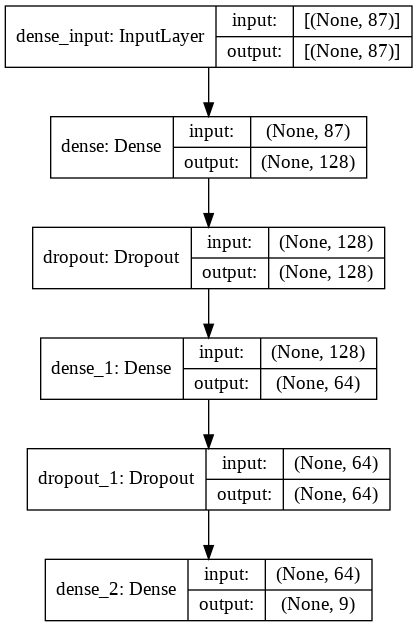

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.summary()
plot_model(model, to_file='chatbot_model.png', show_shapes=True)

In [ ]:
#Compilando el modelo. SGD con gradiente acelerado Nesterov da buenos resultados
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
10/10 [==============================] - 1s 1ms/step - loss: 2.2787 - accuracy: 0.0575
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 2.1614 - accuracy: 0.1701
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 2.0592 - accuracy: 0.2891
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 1.9800 - accuracy: 0.2059
Epoch 5/200
10/10 [==============================] - 0s 1ms/step - loss: 1.9226 - accuracy: 0.3587
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 1.6627 - accuracy: 0.5920
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 1.6451 - accuracy: 0.4791
Epoch 8/200
10/10 [==============================] - 0s 1ms/step - loss: 1.3970 - accuracy: 0.6710
Epoch 9/200
10/10 [==============================] - 0s 2ms/step - loss: 1.4250 - accuracy: 0.6378
Epoch 10/200
10/10 [==============================] - 0s 2ms/step - loss: 1.2191 - accuracy: 0.7956
Epoch 11/

In [ ]:
#Guardando el modelo
model.save('chatbot_model.h5', hist)

## Interactuando con el chatbot

El modelo está listo para chatear, lo siguiente es crear una interfaz gráfica de usuario para el chatbot.

Se usa el módulo Tkinter para construir la estructura de la aplicación de escritorio y luego se captura el mensaje del usuario y nuevamente realizar un procesamiento previo antes de ingresar el mensaje en el modelo entrenado.

El modelo predecirá la etiqueta del mensaje del usuario, y se seleccionará aleatoriamente la respuesta desde la lista de respuestas en el archivo 'intents.json'

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Data Science/Chatbot/chatbot_model.h5')

In [ ]:
def clean_up_sentence(sentence):
  #tokenizando el patrón - dividiendo las palabras en una lista
  sentence_words = nltk.word_tokenize(sentence)
  #Reduciendo las palabras a su forma base
  sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
  
  return sentence_words

def bag_of_words(sentence, words, show_details=True):
  #Tokenizando patrones
  sentence_words = clean_up_sentence(sentence)
  #Conjunto de palabras - matriz de vocabulario
  bag = [0] * len(words)
  for s in sentence_words:
    for i, word in enumerate(words):
      if word == s:
        #Se asigna 1 si la palabra actual está en la posición del vocabulario
        bag[i] = 1
        if show_details:
          print('found in bag: %s' % word)
  
  return(np.aray(bag))

def predict_class(sentence):
  #filtro por debajo del umbral de predicción
  p = bag_of_words(sentence, words, show_details=True)
  res = model.predict(np.array([p]))[0]
  ERROR_THRESHOLD = 0.25
  results = [[i,r] for i,r in enumerate(res) if r > ERROR_THRESHOLD]
  #probabilidad de resistencia de clasificación
  result.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in results:
    result_list.append({'intent ': classes[r[0]], 'probability ': str(r[1])})
  
  return return_list

def getResponse(ints, intents_json):
  tag = ints[0]['intent']
  list_of_intents = intents_json['intents']
  for i in list_of_intents:
    if(i['tag'] == tag):
      result = random.choice(i['responses'])
      break
  
  return result

In [ ]:
#Creando la GUI con Tkinter
import tkinter
from tkinter import *

def send():
  msg = EntryBox.get('1.0', 'end-1c').strip()
  EntryBox.delete('0.0', END)
  if msg != '':
    ChatBox.config(state=NORMAL)
    ChatBox.insert(END, 'You: ' + msg + +'\n\n')
    ChatBox.config(foreground='#446665', font=('Verdana', 12))
    ints = predict_class(msg)
    res = getResponse(ints, intents)

    ChatBox.insert(END, 'Bot: ' + res + '\n\n')
    ChatBox.config(state=DISABLE)
    ChatBox.yview(END)

root = Tk() #No funciona en colab, no dispone de entorno
root.title('ChatBot')
root.geometry('400x500')
root.resizable(width=FALSE, height=FALSE)

#Ventana de chat
ChatBox = Text(root, bd=0, bg='white', height='8', width='50', font='Arial',)
ChatBox.config(state=DISABLE)
#Vinculando barra de desplazamiento a ventana de chat
scrollbar = Scrollbar(root, command=ChatBox.yview, cursor='heart')
ChatBox['yscrollcommand'] = scrollbar.set
#Boton para enviar mensaje
SendButton = Button(root, font=('Verdana', 12, 'bold'), text='Send', width='12', height=5,
                    bd=0, bg='f9a602', activebackground='#3c9d9b', fg='##000000',
                    command=send)
#Caja para ingresar el mensaje
EntryBox = Text(root, bd=0, bg='white', width='29', height='5', font='Arial')
# EntryBox.bind('<Return>', send)

#Ubicando todos los componentes en la pantalla
scrollbar.place(x=376, y=6, height=386)
ChatBox.place(x=6, y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)
root.mainloop()

TclError: ignored